# Online Status Count Analysis

## Preparation

The following two scripts are activated to:
1. Set up the MongoDB connection and
2. Read the pre-generated ID-table to fetch names of roles and channels.

In [2]:
%run -i scripts/setup-mongo.py
%run -i scripts/read-idtable.py

In [6]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date

In [3]:
# Get messages collection
coll_status = mongo_db['status']

## Status Counts over Time

First of all, we prepare a method to fetch data and generate a plot of all online states of the specified count of last days.

In [4]:
def status_plot_last_x_days(days):
    status_data = coll_status.find({
        'timestamp': {
            '$gte': datetime.today() - timedelta(days=days)
        }
    })
    
    online = []
    offline = []
    dnd = []
    away = []
    dates = []
    
    i = 0
    for s in status_data.clone():
        i += 1
        # Only take every 2nd value
        if i % 2 == 0:
            continue
        
        # Some of the offline values are errous and
        # value to 0, so this filters these values
        # out for a cleaner result.
        offl = s.get('offline')
        if offl == 0:
            offl = offline[-1]
        offline.append(offl)
        
        online.append(s.get('online'))
        dnd.append(s.get('dnd'))
        away.append(s.get('away'))
        dates.append(s.get('timestamp'))
        
        
    fig = plt.figure(figsize=(14, 8), dpi=80)
    a1 = fig.add_axes([0, 0, 1, 1])
    a1.plot(dates, online, 'g')
    a1.plot(dates, dnd, 'r')
    a1.plot(dates, away, 'y')
#   a2 = a1.twinx()
#   a2.plot(dates, offline, 'b')
    fig.legend(('online', 'dnd', 'away'), loc='upper left')
    plt.show()

So, this is the evolution of player counts for each online status (`online`, `dnd`, `away`) over the last 30 days.

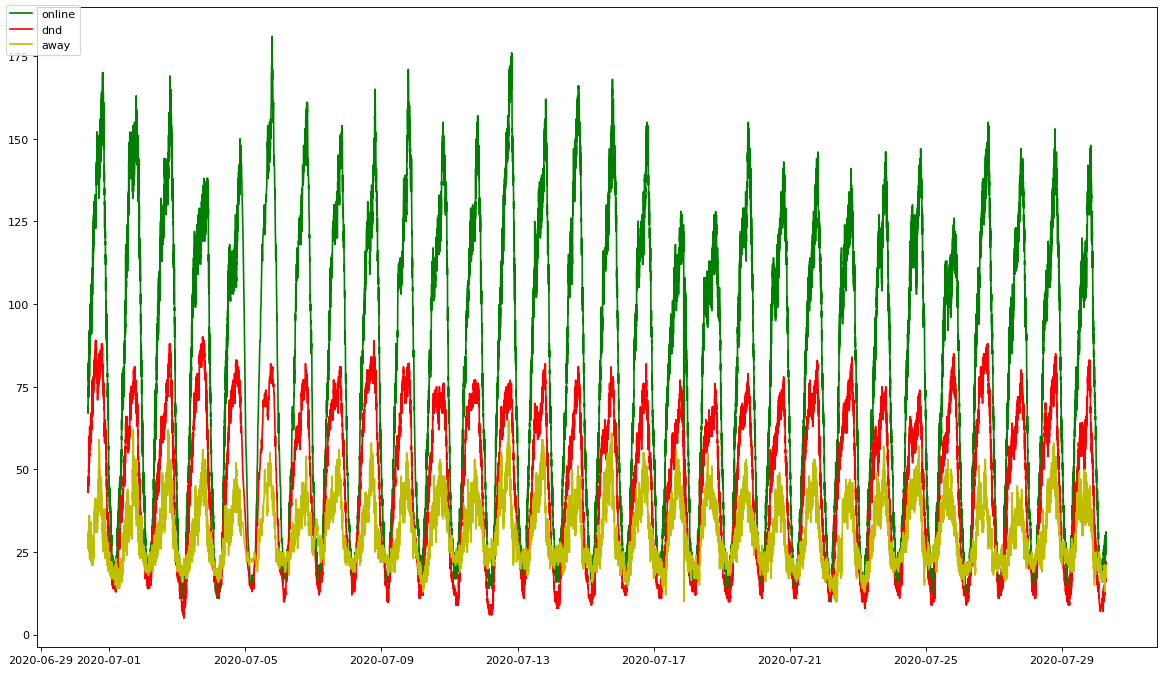

In [5]:
status_plot_last_x_days(30)

And this is a more detailed view over the last 7 days.

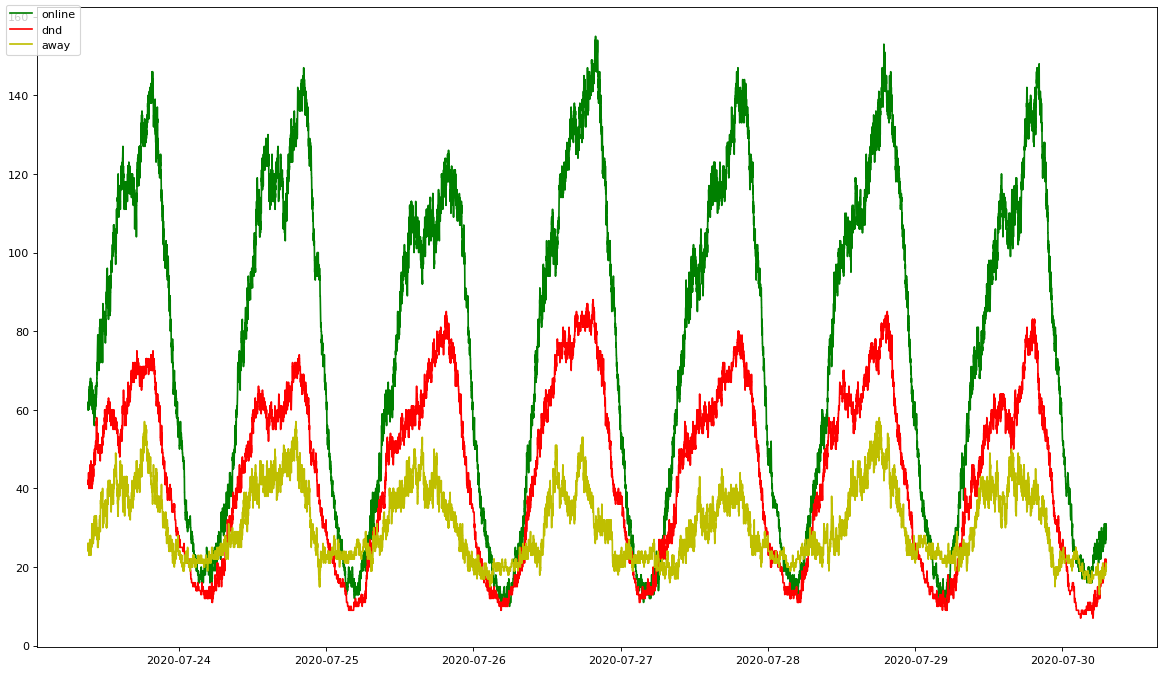

In [6]:
status_plot_last_x_days(7)

## Average Count of Online Users over Time

In the following chart you see the evolution of online users for each status averaged over the time span of a day over time.

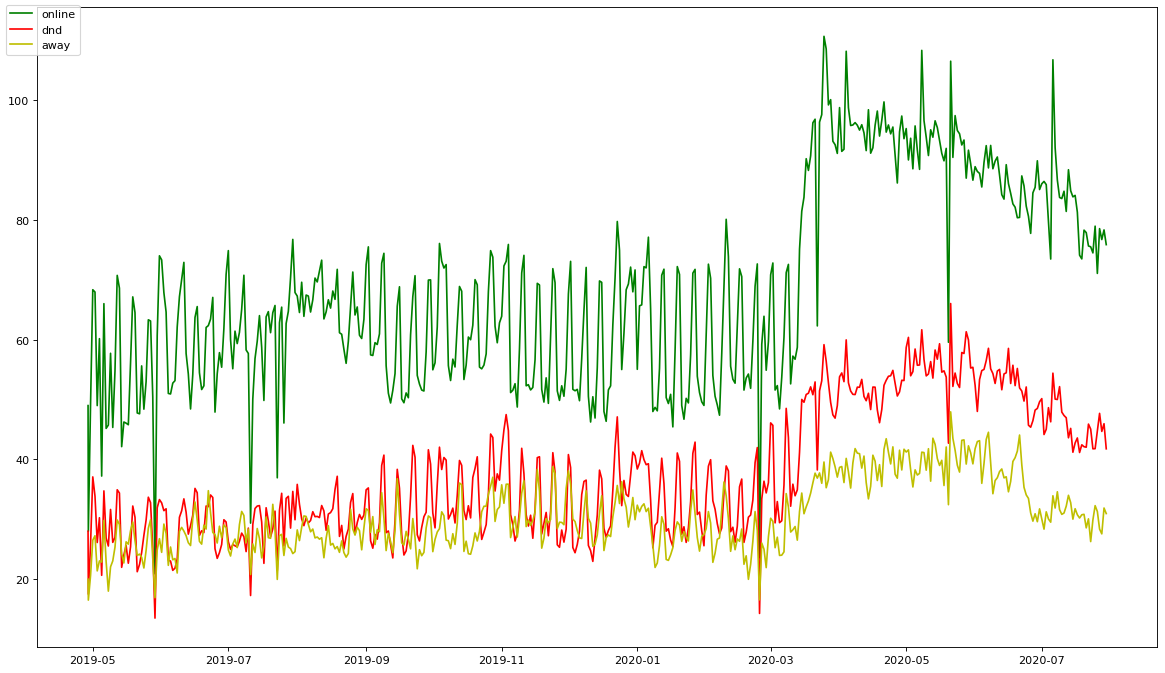

In [7]:
status_data = coll_status.find({})

online = []
offline = []
dnd = []
away = []
dates = []

c_online = 0
c_offline = 0
c_dnd = 0
c_away = 0

last_day = 1
i = 0
for s in status_data.clone():
    date = s.get('timestamp')
    c_online += s.get('online')
    c_offline += s.get('offline')
    c_dnd += s.get('dnd')
    c_away += s.get('away')
    i += 1
    if last_day != date.day:
        last_day = date.day
        online.append(c_online / i)
        offline.append(c_offline / i)
        dnd.append(c_dnd / i)
        away.append(c_away / i)
        dates.append(date)
        c_online = 0
        c_offline = 0
        c_dnd = 0
        c_away = 0
        i = 0
        
fig = plt.figure(figsize=(14, 8), dpi=80)
a1 = fig.add_axes([0, 0, 1, 1])
a1.plot(dates, online, 'g')
a1.plot(dates, dnd, 'r')
a1.plot(dates, away, 'y')
# a2 = a1.twinx()
# a2.plot(dates, offline, 'b')
fig.legend(('online', 'dnd', 'away'), loc='upper left')
plt.show()

## Status Statistics per Role

For this analysis, we are using another data collection named `statusroles` which also recorded the ammount of members online for each online status, but this time split up to each role on the guild.

The idea was to analyze if the patterns differ by role. So I thought it would be possible to see if a specific roles is more active at other times than other roles, for example.

But as you can see, because the ammount of users in these roles in not quiet high - only around 10 or so users per role - the graph is distorted and does not really show much information, sadly.

Maybe, it would be possible to smooth out the data a bit to give more overview, but I have no idea how to do that to be honest. :D

In [14]:
coll_status_roles = mongo_db['statusroles']

In [18]:
def status_roles_plot_last_x_days(days):
    # Object with following structure:
    # { 'role_name': { 'date': count } }
    role_stats = {
        'Admin': {},
        'Moderator': {},
        'Supporter': {},
        'Bot': {},
    }

    status_roles_data = coll_status_roles.find({
        'timestamp': {
            '$gte': datetime.today() - timedelta(days=days)
        }
    })

    i = 0
    for s in status_roles_data.clone():
        i += 1
        if i % 2 > 0:
            continue
        ts = s.get('timestamp')
        for r in s.get('roles'):
            r_name = get_role_name(r.get('roleid'))
            count = r.get('online') + r.get('dnd') + r.get('away')
            if r_name not in role_stats:
                continue
            role_stats[r_name][ts] = count


    fig = plt.figure(figsize=(14, 8), dpi=80)

    legends = []
    for r_name, v in role_stats.items():
        plt.plot(list(v.keys()), list(v.values()))
        legends.append(r_name)

    fig.legend(legends, loc='upper left')
    plt.show()

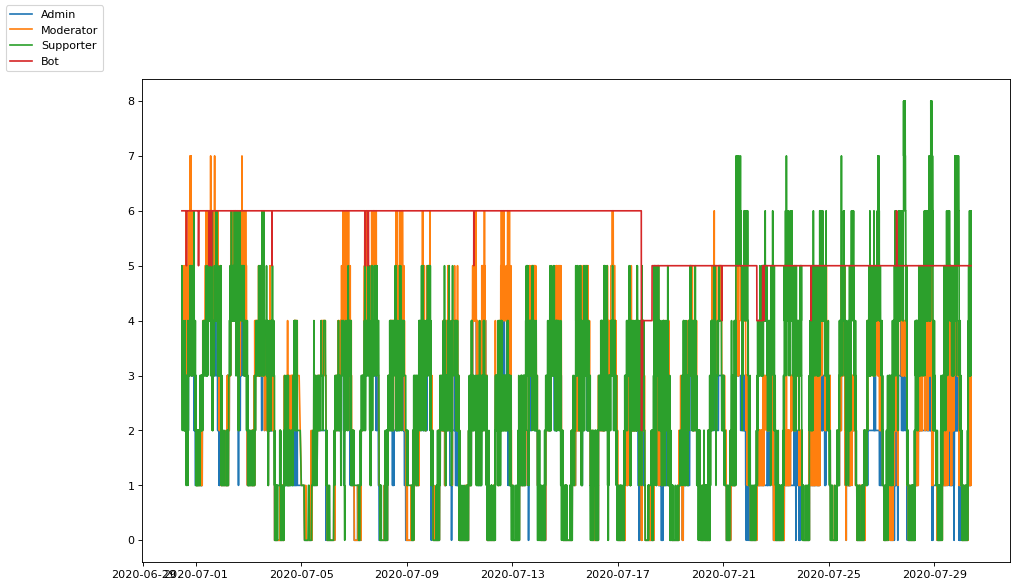

In [19]:
status_roles_plot_last_x_days(30)

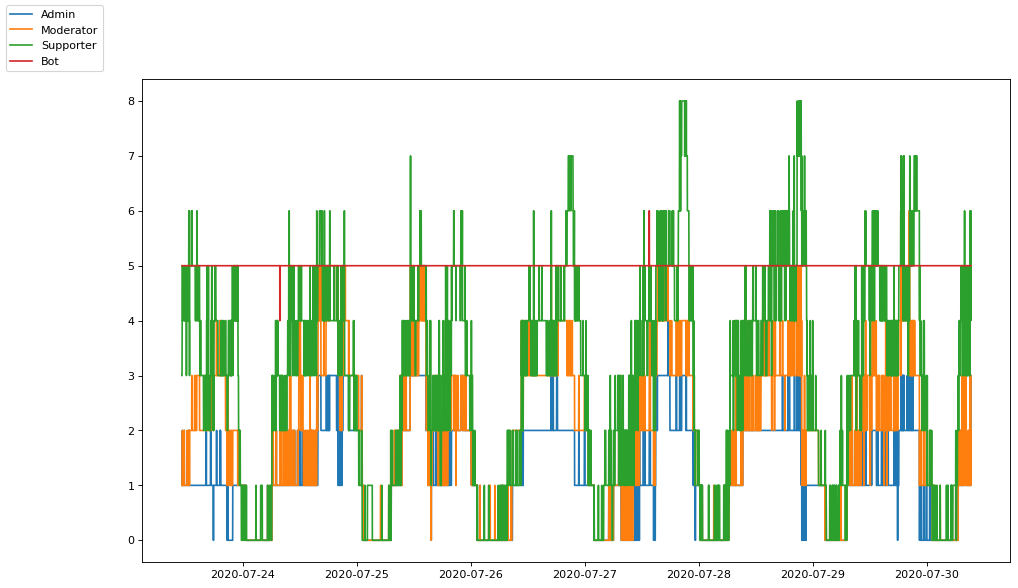

In [20]:
status_roles_plot_last_x_days(7)